In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Preciptation in Inches')

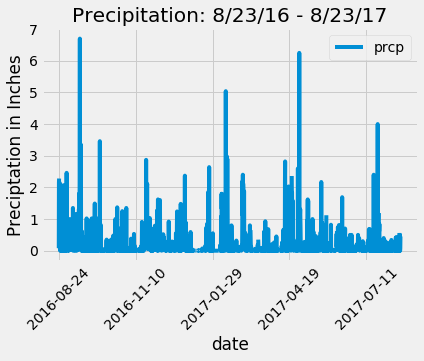

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latestdate
# Calculate the date 1 year ago from the last data point in the database
oneyearago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
oneyearago
# Perform a query to retrieve the data and precipitation scores
precipitation = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > oneyearago)
                  .order_by(Measurement.date)
                  .all())
# Save the query results as a Pandas DataFrame and set the index to the date column
prcptable = pd.DataFrame(precipitation)
prcptable = prcptable.set_index('date')
# Sort the dataframe by date
prcptable = prcptable.sort_index(ascending=True)
prcptable.head()
# Use Pandas Plotting with Matplotlib to plot the data
prcptable.plot(title="Precipitation: 8/23/16 - 8/23/17")
plt.xticks(rotation=45)
plt.ylabel("Preciptation in Inches")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcptable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()
stations_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_activity = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stations_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = (session.query(Measurement.station)
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .first())
print(f"The most active station is {most_active [0]}.")

#lowest temperature
lowest_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == most_active[0])
                      .order_by(Measurement.tobs.asc())
                      .first())
print(f"The lowest temperature is {lowest_temp[0]} degrees Farenheit.")

#highest temperature
highest_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == most_active[0])
                      .order_by(Measurement.tobs.desc())
                      .first())
print(f"The highest temperature is {highest_temp[0]} degrees Farenheit.")

#average temperature
avg_temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == most_active[0]))
avg_temp = '{0:.3}'.format(avg_temp[0][0]) 
print(f"The average temperature is {avg_temp} degrees Farenheit.")



The most active station is USC00519281.
The lowest temperature is 54.0 degrees Farenheit.
The highest temperature is 85.0 degrees Farenheit.
The average temperature is 71.7 degrees Farenheit.


Text(0.5, 1.0, 'Last 12 months of TOBS')

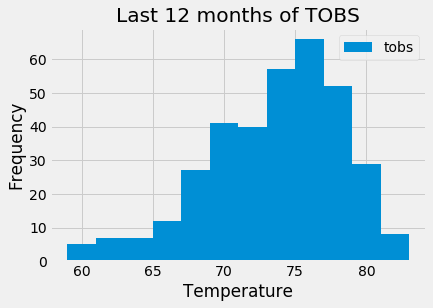

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#query for the last year of temperature data

#most observed
most_observed = (session.query(Measurement.station, Measurement.tobs)
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.tobs).desc())
                        .first())

most_observed

#last 12 months of temperature data
temp_data = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > oneyearago)
                   .filter(Measurement.station == most_observed[0])
                   .order_by(Measurement.date)
                   .all())

#convert query object to data frame
temp_table = pd.DataFrame(temp_data)
temp_table = temp_table.set_index('date')

#sory by date
temp_table = temp_table.sort_index(ascending=True)

#histogram plot with pandas
temp_table.plot(kind='hist', bins=12)
plt.xlabel("Temperature")
plt.title("Last 12 months of TOBS")
